In [17]:
import copy, random, matplotlib
import pandas as pd
import csv 
import numpy as np
import json
import math
from decimal import Decimal
import statistics
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams["font.size"] = 16

In [4]:
df = pd.read_csv('MonthlyPositionTrackerCSVFormat.csv', header=0, squeeze=True)
df_police = df[df['Location'] == 'POLICE']
df_police = df_police[df_police['Year'] == 2017]
df_police = df_police[df_police['Month'] == 'March']
df_police.head()

,Position #,Position Description,FTE Percent,Location,2019 Budgeted Salary,Employee #,Filled Position Description,Filled FTE Percent,Current Salary,Month,Year
1248,2198,POLICE OFFICER,1.0,POLICE,76631.0,3935,POLICE OFFICER,1.00,57495.62,March,2017.0
1249,2199,POLICE SGT.,1.0,POLICE,89864.0,3085,POLICE SGT.,1.00,84160.7,March,2017.0
1250,2200,POLICE OFFICER,1.0,POLICE,80431.0,2200,POLICE OFFICER,1.00,74732.84,March,2017.0
1251,2201,POLICE OFFICER,1.0,POLICE,83597.0,4006,POLICE OFFICER,1.00,77698.4,March,2017.0
1252,2203,POLICE OFFICER,1.0,POLICE,80431.0,3629,POLICE OFFICER,1.00,75325.9,March,2017.0


In [5]:
def simulation_parameters(agency,position):
    ## Enter desired location/agency 'POLICE'
    location = agency
    ## Enter desired position 'POLICE SGT.'
    position = position

    full_df = pd.read_csv('SimulationMonthlyAnalysis.csv', header=1, squeeze=True)
    filtered_df = full_df[full_df['Location'] == location]
    filtered_df = filtered_df[filtered_df['Filled Position Description'] == position]

    ## create an object to make json
    json_out = {'PROMOTION_PROB_PER_EMP': 0, 'PROMOTION_AMOUNT': 0, 'RETIRE_PROB_PER_EMP':0, 'HIRE_PROB':0, 'START_SALARY':0}
    df2 = pd.read_csv('SimulationMonthlyAnalysis.csv', header=1, squeeze=True)
    df_police_agency = df2[df2['Location'] == location]
    
    ### Find probability of promotion and retirement
    df2 = pd.read_csv('SimulationMonthlyAnalysis.csv', header=1, squeeze=True)
    df2_location = df2[df2['Location'] == location]

    header_names = list(df2_location)
    employee_columns = []
    current_salary_columns = []

    for i in header_names:
        if i[0:8] == 'Employee':
            employee_columns.append(i)
        else:
            pass

    for i in header_names:
        if i[0:14] == 'Current Salary' or i[0:15] == ' Current Salary':
            current_salary_columns.append(i)
        else:
            pass
    
    retired_total = 0
    promoted_total = 0
    promotion_amount = 0.0
    hired_total = 0
    starting_salary = 0.0

    for idx, val in enumerate(employee_columns):
        if idx == len(employee_columns)-1:
            break
        for i in filtered_df[employee_columns[idx]].values:
            if i == 'VACANT':
                continue
            i = str(i)
            if i not in df2_location[employee_columns[idx+1]].values:
                retired_total += 1
            elif i in df2_location[employee_columns[idx+1]].values and i not in filtered_df[employee_columns[idx+1]].values:
                if i == 'VACANT':
                    pass
                else:
                    promoted_total += 1
                    employee_new_salary_df = df2_location[df2_location[employee_columns[idx+1]] == i]
                    employee_old_salary_df = filtered_df[filtered_df[employee_columns[idx]] == i]
                    promotion_amount += float(employee_new_salary_df[current_salary_columns[idx+1]].values) - float(employee_old_salary_df[current_salary_columns[idx]].values)
            else:
                pass

    try:
        retired_prob = round(((retired_total / (len(employee_columns) - 1))/100), 5)
        retired_prob
        json_out['RETIRE_PROB_PER_EMP'] = retired_prob
    except:
        json_out['RETIRE_PROB_PER_EMP'] = 0.0

    try:
        promoted_prob = round(((promoted_total / (len(employee_columns) - 1))/100), 5)
        promoted_prob
        json_out['PROMOTION_PROB_PER_EMP'] = promoted_prob
    except:
        json_out['PROMOTION_PROB_PER_EMP'] = 0.0

    try:
        promotion_amount = round(((promotion_amount / promoted_total)/100), 5)
        promotion_amount
        json_out['PROMOTION_AMOUNT'] = promotion_amount
    except:
        json_out['PROMOTION_AMOUNT'] = 0.0  
    
    for idx, val in enumerate(employee_columns):
        if idx == len(employee_columns)-1:
            break
        for i in filtered_df[employee_columns[idx+1]].values:
            i = str(i)
            if i not in df2_location[employee_columns[idx]].values:
                hired_total += 1
                salary_df = filtered_df[filtered_df[employee_columns[idx+1]] == i]
                starting_salary += float(salary_df[current_salary_columns[idx+1]].values)
            else:
                pass

    try:
        hired_prob = round(((hired_total / (len(employee_columns) - 1))/100), 5)
        hired_prob
        json_out['HIRE_PROB'] = hired_prob
    except:
        json_out['HIRE_PROB'] = 0.0

    try:
        if hired_total > 0:
            starting_salary = round(((starting_salary / hired_total)/100), 5)
            json_out['START_SALARY'] = starting_salary
        else:
            ## TODO: look for people who got a promotion to this position and then find their starting salary
            starting_salary = round((sum(filtered_df['Current Salary'].values) / len(filtered_df['Current Salary'].values)), 5)
            json_out['START_SALARY'] = starting_salary
    except:
        json_out['START_SALARY'] = 0.0
    
    json_out
    #json_probs = json.dumps(json_out)
    return(json_out)
     

In [6]:
list1 = df_police.to_dict(orient='records')
list2 = []
for index in range(len(list1)):
    # hard coded to avoid some runtime errors
    if list1[index]['Employee #'] == 'VACANT' or list1[index]['Filled Position Description'] == 'POLICE RCDS SVS CLK' or list1[index]['Filled Position Description'] == 'VACANT' or list1[index]['Filled Position Description'] == 'POLICE PROPERTY CLK-16':
        pass
    else:
        list2.append(list1[index])
list1 = list2

In [7]:
positions = []
for index in range(len(list1)):
    if list1[index]['Filled Position Description'] not in positions :
        positions.append(list1[index]['Filled Position Description'])
del positions[19] # hard code to avoid runtime error
percentages = {}
for i in range(len(positions)):
    try:
        percentages[str(positions[i])] = simulation_parameters('POLICE',positions[i])
    except:
        pass


In [8]:
police = {}

for x in list1:
    police.update({x['Employee #']: x})
    
for i in police:
    try:
        police[i]['Current Salary'] = float(police[i]['Current Salary'])
        police[i]['2019 Budgeted Salary'] = float(police[i]['2019 Budgeted Salary'])
    except:
        pass


In [9]:
# generate unique fake employee IDs

next_id = 1000
def gen_emp_id():
    global next_id
    next_id += 1
    return str(next_id)


In [10]:
from math import isnan

In [11]:
def simulate_one_month(prior_employees):
    employees = copy.deepcopy(prior_employees)
  
    # simulate promotions 
    for employee in employees.keys():
        pos_name = employees[employee]['Filled Position Description']
        try:
            if random.random() < percentages.get(pos_name).get('PROMOTION_PROB_PER_EMP'):
                employees[employee]['2019 Budgeted Salary'] += percentages.get(pos_name).get('PROMOTION_AMOUNT')
        except:
            pass
        
    # simulate retiring
    emp_ids = list(employees.keys())
    for eid in emp_ids:
        pos_name = employees[eid]['Filled Position Description']
        try:
            if random.random() < percentages[pos_name]['RETIRE_PROB_PER_EMP']:
                employees.pop(eid)
        except:
            pass
        
    # simulate hiring
    emp_ids2 = list(employees.keys())
    for eid in emp_ids2:
        pos_name = employees[eid]['Filled Position Description']
        try:
            if random.random() < percentages[pos_name]['HIRE_PROB']:
                employees[gen_emp_id()] = {'Position #': '2198',
                                  'Position Description': pos_name,
                                  'FTE Percent': 1.0,
                                  'Location': 'POLICE',
                                  '2019 Budgeted Salary': employees[eid]['Current Salary'],
                                  'Current Salary': employees[eid]['Current Salary'],
                                  'Employee #': '9999',
                                  'Filled Position Description': pos_name,
                                  'Filled FTE Percent': 1.00,
                                  'Month': 'March',
                                  'Year': 2019.0}
        except:
            pass
    return employees



In [12]:
def sim_months(start, months):
    history = [start]
    for i in range(months):
        history.append(simulate_one_month(history[-1]))
    return history


In [13]:
history = sim_months(police, 120)


In [14]:
def employees_each_month(history):
    count = []
    for snapshot in history:
        count.append(len(snapshot))
    return pd.Series(count)

def salary_each_month(history):
    salaries = []
    for snapshot in history:
        total = 0
        index = 0
        for emp in snapshot.keys():
            try:
                total += history[index][emp]['Current Salary']
            except:
                pass
        salaries.append(total)
        index += 1
    return pd.Series(salaries)



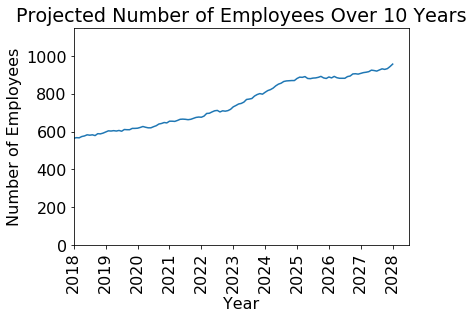

In [15]:
s = employees_each_month(history)
ax = s.plot.line(xlim=0, ylim=(0,1150))
ax.set_xlabel("Year")
ax.set_ylabel("Number of Employees")
ax.set_title("Projected Number of Employees Over 10 Years")
plt.xticks([0,12,24,36,48,60,72,84,96,108,120],['2018','2019','2020','2021','2022','2023','2024','2025','2026','2027','2028'],rotation=90)
None

In [18]:
salaries = []

for i in range(1000):
    history = sim_months(police, 120)
    total = 0
    for employee in history[-1].values():
        total += employee['Current Salary']
    salaries.append(total)
salaries[:10]

[53740046.89000023,
 57586815.540000334,
 65486134.210000426,
 62152847.1200003,
 71249658.72000033,
 67064412.06000041,
 64085698.540000446,
 75237082.65000026,
 71134559.84000042,
 61853982.82000033]

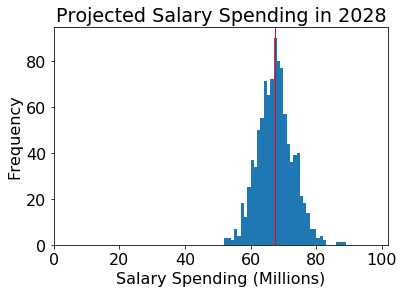

In [19]:
s_mean = statistics.mean(salaries)
s_mean = s_mean / 1000000
s = pd.Series(salaries) / 1000000
ax = s.plot.hist(xlim=0, bins=range(40,100,1))
ax.set_xlabel("Salary Spending (Millions)")
ax.set_title("Projected Salary Spending in 2028")
ax.axvline(s_mean, color='r', linestyle='solid', linewidth=1)
None